# 0. Imports

In [ ]:
!pip install transformers

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

plt.rcParams['figure.figsize'] = (15,5)

# 1. Data

In [5]:
#Leemos Datasets
train = pd.read_csv('/content/drive/My Drive/train.csv', sep = '|')
test = pd.read_csv('/content/drive/My Drive/test_santander.csv')

#String de categorias -> Int
label_encoder = LabelEncoder().fit(train['Intencion'])
train.loc[:,'Intencion'] = label_encoder.transform(train['Intencion'])

#Split train/test sets
X_train, X_test, y_train, y_test = train_test_split(train['Pregunta'],
                                                    train['Intencion'], 
                                                    test_size = 0.1, 
                                                    random_state = 1)

In [6]:
X_train.shape, X_test.shape

((18093,), (2011,))

In [7]:
np.array(X_train)[0], np.array(y_train)[0]

('me puedo dar de alta en club la nacion desde acá?', 194)

In [8]:
print('Pregunta mas larga:',max([len(x.split(' ')) for x in X_train]))

Pregunta mas larga: 43


In [9]:
#Numero de categorias presentes
CLASSES = y_train.nunique()
CLASSES

352

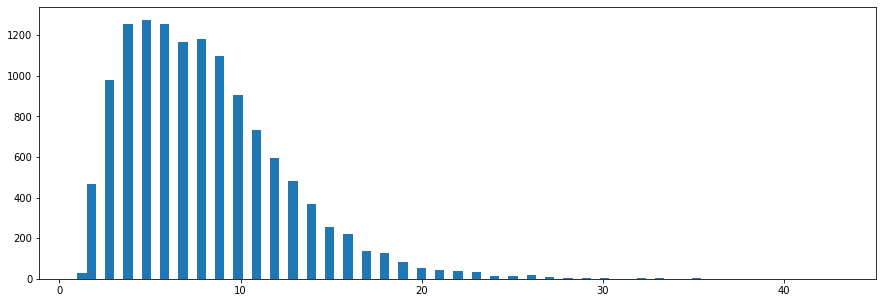

In [ ]:
#Histograma de las longitudes de las pregunas
plt.hist([len(x.split(' ')) for x in X_train], bins = 'auto')
plt.show()

# 2. Create dataset

In [10]:
#Cargamos los pesos y vocabulario del modelo BETO (BERT entrenado con textos en español)
#La librería transformers nos facilita clases para tokenizar los inputs segun lo requiera cada modelo
#En este caso usaré BertTokenizer
BERT_PRETRAINED_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_NAME)

El modelo BERT debe ser alimentado con un formato especial. Al inicio de la oración, debe apendarse un token especial [CLS], un token especial al final de la misma [SEP] y tokens para el padding [PAD]. BERT fue entrenado con subwords, la clase BertTokenizer nos ayuda con esta tarea, al igual que todo el preprocesado neceesario para dejar listo los inputs del modelo.

In [11]:
ejemplo = 'Hola, quisiera hacer un deposito con mi tarjeta de crédito, cuales son los pasos'
tokens = tokenizer.tokenize(ejemplo)
ids = tokenizer.convert_tokens_to_ids(tokens)
full = tokenizer.encode_plus(ejemplo,
                             max_length=32,
                             add_special_tokens=True,
                             return_token_type_ids=False,
                             padding='max_length',
                             return_attention_mask=False,
                             return_tensors='pt')

print('Original:',ejemplo,'\n')
print('Tokenizado:',tokens,'\n')
print('Full tokenized', tokenizer.convert_ids_to_tokens(full['input_ids'].numpy()[0]),'\n')
print('Full ids:',full['input_ids'],'\n')

Original: Hola, quisiera hacer un deposito con mi tarjeta de crédito, cuales son los pasos 

Tokenizado: ['Hola', ',', 'quisiera', 'hacer', 'un', 'deposit', '##o', 'con', 'mi', 'tarjeta', 'de', 'crédito', ',', 'cuales', 'son', 'los', 'pasos'] 

Full tokenized ['[CLS]', 'Hola', ',', 'quisiera', 'hacer', 'un', 'deposit', '##o', 'con', 'mi', 'tarjeta', 'de', 'crédito', ',', 'cuales', 'son', 'los', 'pasos', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 

Full ids: tensor([[    4,  1894,  1017,  6241,  1409,  1049, 17756, 30933,  1051,  1153,
          7929,  1008,  4792,  1017,  3556,  1404,  1065,  8601,     5,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1]]) 



In [12]:
#Creo una funcion para obtener un objeto dataset con el encoding necesario para el modelo.

def encode_examples(X, y, max_len):
  '''
  Devuelve un generador (tf.data.Dataset). 
  Los inputs son tokenizados -> convertidos a su index -> agrega tokens especiales [CLS] [PAD] [SEP]
  Args:
      X = (pd.DataFrame/pd.Series/np.array/list) - Preguntas
      y = (pd.DataFrame/pd.Series/np.array/list) - Categorias
  '''
    input_ids_list = []
    label_list = []
    
    for pregunta, label in zip(X,y):
        bert_input = tokenizer.encode_plus(pregunta,
                                           truncation = True,
                                           max_length = max_len,
                                           add_special_tokens = True,
                                           return_token_type_ids = False,
                                           padding='max_length',
                                           return_attention_mask = False,
                                           return_tensors='tf')

        input_ids_list.append(tf.reshape(bert_input['input_ids'], (max_len)))
        label_list.append(tf.squeeze([label], axis = -1))
    
    return tf.data.Dataset.from_tensor_slices((input_ids_list, label_list))

In [13]:
#Selecciono 32 tokens por pregunta como maximo para el modelo
MAX_LEN = 32

In [15]:
#Creamos un dataset para train, validation y test set.
train_dataset = encode_examples(X_train, y_train, MAX_LEN).batch(16)
test_dataset = encode_examples(X_test, y_test, MAX_LEN).batch(1)

In [ ]:
#Tomo un ejemplo del generador del test para ver su salida
example = next(iter(test_dataset))
example[0]

<tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[    4,  1129,  7214,  1038,  2345,  1030, 12655,  1008,  1030,
         2405, 30932,  4178, 10396,  1093,  1042,  1129, 15925,  1022,
         1040, 20576, 30932,     5,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1]], dtype=int32)>

In [ ]:
example[1]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([342], dtype=int32)>

# 3. Training

In [16]:
#La librería transformers nos facilita la clase TFBertModel, que carga los pesos entrenados y nos devuelve los layers de tensorflow.
bert = TFBertModel.from_pretrained(BERT_PRETRAINED_NAME,from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#BERT espera 32 tokens int, y nos devuelve: (sacado de la documentación de huggingface)
#last_hidden_state ->  Sequence of hidden-states at the output of the last layer of the model.
#pooler_output -> Last layer hidden-state of the first token of the sequence (classification token) 
#                 further processed by a Linear layer and a Tanh activation function. 
#                 The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.
#                 This output is usually not a good summary of the semantic content of the input, 
#                 you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence.

bert(example[0])[0].shape, bert(example[0])[1].shape

(TensorShape([1, 32, 768]), TensorShape([1, 768]))

![im](https://miro.medium.com/max/2606/1*LwOHGvXADWzz5S9tYonNeg.png)

In [17]:
#Se le asigna un peso a cada clase, dependiendo de su cantidad de apariciones en el dataset
#Esto ayuda a que el modelo preste mas atencion a las clases con pocos datos
weights = compute_class_weight('balanced', 
                               np.unique(y_train), 
                               y_train)

cw = dict(enumerate(weights))

In [18]:
#La clase 7 tiene menor ocurrencia, se le asigna un peso mayor
cw[7], cw[1]

(51.40056818181818, 0.11602837061358506)

In [19]:
#Para clasificación, se utiliza el pooler output, es decir la salida del token [CLS]
#Input -> Solo los index de los tokens (en teoría se debería tambien alimentar con un array "attention mask")
#Bert pre entrenado -> Tomamos el vector resultante de [CLS] (pooler_output)
#Dropout -> Regularización
#Output -> Una capa densa con una cantidad de neuronas igual a la cantidad de clases
input_layer = keras.layers.Input(shape = (MAX_LEN,), dtype = tf.int32)
hidden_states, pooler_output = bert(input_layer)
dropout = keras.layers.Dropout(0.35)(pooler_output)
output = keras.layers.Dense(CLASSES, activation='softmax')(dropout)

model = keras.models.Model(inputs = input_layer,
                           outputs = output)

#Segun el paper, el mejor parametro para learning_rate cuando se hace fine tuning es 2e-5
#Sparse Categorical crossentropy -> Para multiples clases, espera que el target sea un int
#Metrica accuracy
model.compile(keras.optimizers.Adam(learning_rate = 2e-5),
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 32, 768), (None,  109850880 
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 352)               270688    
Total params: 110,121,568
Trainable params: 110,121,568
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Callback para detener el entrenamiento una vez que han transcurrido 5 epochs sin mejorar el val_accuracy
callback = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                         patience = 5)

#Entrenamos el modelo
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs = 100,
                    callbacks = [callback],
                    class_weight = cw)

Epoch 1/100
1131/1131 [==============================] - 202s 178ms/step - loss: 5.9787 - accuracy: 0.0020 - val_loss: 5.7883 - val_accuracy: 0.0060
Epoch 2/100
1131/1131 [==============================] - 199s 176ms/step - loss: 5.0949 - accuracy: 0.0594 - val_loss: 4.0241 - val_accuracy: 0.2422
Epoch 3/100
1131/1131 [==============================] - 200s 176ms/step - loss: 3.1126 - accuracy: 0.3240 - val_loss: 2.6020 - val_accuracy: 0.4898
Epoch 4/100
1131/1131 [==============================] - 200s 177ms/step - loss: 1.7745 - accuracy: 0.5433 - val_loss: 1.7772 - val_accuracy: 0.6390
Epoch 5/100
1131/1131 [==============================] - 199s 176ms/step - loss: 0.9888 - accuracy: 0.7028 - val_loss: 1.2856 - val_accuracy: 0.7230
Epoch 6/100
1131/1131 [==============================] - 199s 176ms/step - loss: 0.5572 - accuracy: 0.8041 - val_loss: 0.9842 - val_accuracy: 0.7653
Epoch 7/100
1131/1131 [==============================] - 199s 176ms/step - loss: 0.3271 - accuracy: 0.8708

In [ ]:
#Plots de accuracy y loss
f, ax = plt.subplots(ncols = 2)

ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].plot(history.history['accuracy'], label = 'Train')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].plot(history.history['loss'], label = 'Train')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')

ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
#Guardo el modelo entrenado
model.save('/content/drive/My Drive/bert_tensorflow_santander_with_class_weight')

# 4. Evaluation

In [ ]:
#Testeo modelo con una pregunta.
pregunta = 'no me llega el mensaje para poder recuperar mi clave'
testeo = tokenizer.encode_plus(pregunta,
                               max_length=32,
                               add_special_tokens=True,
                               return_token_type_ids=False,
                               padding='max_length',
                               return_attention_mask=True,
                               return_tensors='tf')['input_ids']
print(testeo)
print('El modelo predice que pertenece a la clase:', tf.argmax(model(testeo), axis = 1).numpy()[0])

In [ ]:
#¿La predicción es correcta?
train[train['Intencion']==1].head(5)

In [ ]:
#Predecimos las categorias del archivo de test para subirlo a la página de la competencia.
pred = []
preguntas = []

for i, pregunta in enumerate(test['Pregunta']):
    bert_input = tokenizer.encode_plus(pregunta,
                                     truncation = True,
                                     max_length = MAX_LEN,
                                     add_special_tokens = True,
                                     return_token_type_ids = False,
                                     padding='max_length',
                                     return_attention_mask = False,
                                     return_tensors='tf')

    input = bert_input['input_ids']
    prediction = model(input)
    pred.append(tf.argmax(prediction, axis = 1).numpy()[0])

    if i % 1500 == 0:
        print('Test example n:',i)

submission = pd.DataFrame()
submission['categoria'] = pd.Series(label_encoder.inverse_transform(pred)).map(lambda x: x.split('_')[1])
submission.to_csv('bert_no_class_weight.csv', header = False)